# Backtest Framework: Event Combinations Win Rates

**Fecha**: 2025-10-29  
**Objetivo**: Evaluar win rates de combinaciones de eventos E1-E11

---

## Metodologia

1. **Signal Generation**: Usar eventos como señales de entrada
2. **Forward Returns**: Calcular returns N dias adelante (1d, 3d, 5d, 10d)
3. **Win Rate**: % de trades con return positivo
4. **Expected Return**: Return promedio de todos los trades
5. **Sharpe Ratio**: Risk-adjusted return
6. **Combinaciones**: Analizar eventos individuales + combinaciones de 2-3 eventos

---

In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 10)

print('Libraries loaded successfully')
print(f'Polars version: {pl.__version__}')

Libraries loaded successfully
Polars version: 1.34.0


## 1. Load Data: Daily OHLCV + Events + Watchlist

In [2]:
# Setup paths
project_root = Path.cwd().parent.parent.parent.parent
daily_dir = project_root / 'processed' / 'daily_ohlcv'
watchlist_file = project_root / 'processed' / 'watchlist_E1_E11.parquet'

print(f'Project root: {project_root}')
print(f'Daily OHLCV dir: {daily_dir}')
print(f'Watchlist file exists: {watchlist_file.exists()}')
print()

Project root: D:\04_TRADING_SMALLCAPS
Daily OHLCV dir: D:\04_TRADING_SMALLCAPS\processed\daily_ohlcv
Watchlist file exists: True



In [3]:
# Load daily OHLCV data
print('Loading daily OHLCV data...')
daily_files = list(daily_dir.glob('*/daily.parquet'))
print(f'Found {len(daily_files):,} ticker files')

# Read and concatenate
dfs_daily = []
for i, pf in enumerate(daily_files):
    if i % 1000 == 0:
        print(f'  Loading {i:,}/{len(daily_files):,}...')
    try:
        df = pl.read_parquet(pf)
        if len(df) > 0:
            dfs_daily.append(df)
    except Exception as e:
        pass

df_daily = pl.concat(dfs_daily)
print(f'Loaded {len(df_daily):,} daily records for {df_daily["ticker"].n_unique():,} tickers')
print()
print('Sample:')
print(df_daily.head(5))

Loading daily OHLCV data...


Found 8,617 ticker files
  Loading 0/8,617...


  Loading 1,000/8,617...


  Loading 2,000/8,617...


  Loading 3,000/8,617...


  Loading 4,000/8,617...


  Loading 5,000/8,617...


  Loading 6,000/8,617...


  Loading 7,000/8,617...


  Loading 8,000/8,617...


Loaded 14,763,755 daily records for 8,617 tickers

Sample:
shape: (5, 9)
┌────────┬────────────┬────────┬────────┬───┬──────────┬────────────┬───────┬──────────┐
│ ticker ┆ date       ┆ o      ┆ h      ┆ … ┆ c        ┆ v          ┆ n     ┆ dollar   │
│ ---    ┆ ---        ┆ ---    ┆ ---    ┆   ┆ ---      ┆ ---        ┆ ---   ┆ ---      │
│ str    ┆ date       ┆ f64    ┆ f64    ┆   ┆ f64      ┆ f64        ┆ i64   ┆ f64      │
╞════════╪════════════╪════════╪════════╪═══╪══════════╪════════════╪═══════╪══════════╡
│ MTC    ┆ 2010-10-07 ┆ 6204.0 ┆ 6240.0 ┆ … ┆ 6080.0   ┆ 132543.575 ┆ 31138 ┆ 8.1194e8 │
│ MTC    ┆ 2010-10-08 ┆ 6050.4 ┆ 6123.2 ┆ … ┆ 6089.6   ┆ 12895.3    ┆ 4855  ┆ 7.8643e7 │
│ MTC    ┆ 2010-10-11 ┆ 6136.0 ┆ 6178.4 ┆ … ┆ 6127.2   ┆ 7907.4375  ┆ 3620  ┆ 4.8612e7 │
│ MTC    ┆ 2010-10-12 ┆ 6140.0 ┆ 6176.0 ┆ … ┆ 6155.2   ┆ 9066.1875  ┆ 3874  ┆ 5.5643e7 │
│ MTC    ┆ 2010-10-13 ┆ 6192.0 ┆ 6192.0 ┆ … ┆ 6118.344 ┆ 8267.7875  ┆ 4113  ┆ 5.0764e7 │
└────────┴────────────┴────────┴─────

In [4]:
# Load watchlist with events
print('Loading watchlist...')
df_watchlist = pl.read_parquet(watchlist_file)
print(f'Watchlist: {len(df_watchlist):,} ticker-date combinations')
print()
print('Schema:')
print(df_watchlist.schema)
print()
print('Sample:')
print(df_watchlist.head(5))

Loading watchlist...
Watchlist: 2,939,824 ticker-date combinations

Schema:
Schema({'ticker': String, 'date': Date, 'events': List(String), 'event_count': UInt32})

Sample:
shape: (5, 4)
┌────────┬────────────┬────────────────────┬─────────────┐
│ ticker ┆ date       ┆ events             ┆ event_count │
│ ---    ┆ ---        ┆ ---                ┆ ---         │
│ str    ┆ date       ┆ list[str]          ┆ u32         │
╞════════╪════════════╪════════════════════╪═════════════╡
│ AAC    ┆ 2004-01-02 ┆ ["E5_BreakoutATH"] ┆ 1           │
│ AACB   ┆ 2004-01-02 ┆ ["E5_BreakoutATH"] ┆ 1           │
│ AAI    ┆ 2004-01-02 ┆ ["E5_BreakoutATH"] ┆ 1           │
│ ABAX   ┆ 2004-01-02 ┆ ["E5_BreakoutATH"] ┆ 1           │
│ ABCO   ┆ 2004-01-02 ┆ ["E5_BreakoutATH"] ┆ 1           │
└────────┴────────────┴────────────────────┴─────────────┘


## 2. Calculate Forward Returns (1d, 3d, 5d, 10d)

In [5]:
# Calculate forward returns
print('Calculating forward returns...')

df_returns = (
    df_daily
    .sort(['ticker', 'date'])
    .with_columns([
        # Forward prices
        pl.col('c').shift(-1).over('ticker').alias('c_1d'),
        pl.col('c').shift(-3).over('ticker').alias('c_3d'),
        pl.col('c').shift(-5).over('ticker').alias('c_5d'),
        pl.col('c').shift(-10).over('ticker').alias('c_10d'),
    ])
    .with_columns([
        # Forward returns
        ((pl.col('c_1d') - pl.col('c')) / pl.col('c')).alias('ret_1d'),
        ((pl.col('c_3d') - pl.col('c')) / pl.col('c')).alias('ret_3d'),
        ((pl.col('c_5d') - pl.col('c')) / pl.col('c')).alias('ret_5d'),
        ((pl.col('c_10d') - pl.col('c')) / pl.col('c')).alias('ret_10d'),
    ])
    .select(['ticker', 'date', 'c', 'ret_1d', 'ret_3d', 'ret_5d', 'ret_10d'])
)

print(f'Returns calculated for {len(df_returns):,} records')
print()
print('Sample:')
print(df_returns.head(10))

Calculating forward returns...


Returns calculated for 14,763,755 records

Sample:
shape: (10, 7)
┌────────┬────────────┬───────┬───────────┬───────────┬───────────┬───────────┐
│ ticker ┆ date       ┆ c     ┆ ret_1d    ┆ ret_3d    ┆ ret_5d    ┆ ret_10d   │
│ ---    ┆ ---        ┆ ---   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ str    ┆ date       ┆ f64   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞════════╪════════════╪═══════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ AABA   ┆ 2017-06-19 ┆ 54.61 ┆ -0.011353 ┆ 0.001282  ┆ -0.005493 ┆ -0.00293  │
│ AABA   ┆ 2017-06-20 ┆ 53.99 ┆ 0.0213    ┆ 0.013706  ┆ -0.006483 ┆ 0.030191  │
│ AABA   ┆ 2017-06-21 ┆ 55.14 ┆ -0.008342 ┆ -0.015053 ┆ 0.0       ┆ -0.009975 │
│ AABA   ┆ 2017-06-22 ┆ 54.68 ┆ 0.000914  ┆ -0.01902  ┆ -0.010607 ┆ -0.001463 │
│ AABA   ┆ 2017-06-23 ┆ 54.73 ┆ -0.007674 ┆ 0.007491  ┆ -0.004568 ┆ 0.002193  │
│ AABA   ┆ 2017-06-26 ┆ 54.31 ┆ -0.012337 ┆ -0.003867 ┆ 0.002578  ┆ 0.018965  │
│ AABA   ┆ 2017-06-27 ┆ 53.64 ┆ 0.027964  ┆ 0.01566   

## 3. Join Watchlist + Returns

In [6]:
# Join watchlist with returns
print('Joining watchlist with returns...')

df_backtest = (
    df_watchlist
    .join(df_returns, on=['ticker', 'date'], how='inner')
)

print(f'Backtest dataset: {len(df_backtest):,} signals')
print(f'Tickers: {df_backtest["ticker"].n_unique():,}')
print()
print('Sample:')
print(df_backtest.head(5))

Joining watchlist with returns...


Backtest dataset: 2,939,824 signals
Tickers: 8,546

Sample:
shape: (5, 9)
┌────────┬────────────┬────────────┬────────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ ticker ┆ date       ┆ events     ┆ event_coun ┆ … ┆ ret_1d    ┆ ret_3d    ┆ ret_5d    ┆ ret_10d  │
│ ---    ┆ ---        ┆ ---        ┆ t          ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ str    ┆ date       ┆ list[str]  ┆ ---        ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
│        ┆            ┆            ┆ u32        ┆   ┆           ┆           ┆           ┆          │
╞════════╪════════════╪════════════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ AABA   ┆ 2017-07-05 ┆ ["E10_Firs ┆ 1          ┆ … ┆ -0.018519 ┆ -0.013844 ┆ 0.013664  ┆ 0.048004 │
│        ┆            ┆ tGreenBoun ┆            ┆   ┆           ┆           ┆           ┆          │
│        ┆            ┆ ce"]       ┆            ┆   ┆           ┆           ┆           ┆          │
│ AABA   ┆ 2017-0

## 4. Explode Events: One Row per Event

In [7]:
# Explode events list to create one row per event
print('Exploding events...')

df_exploded = df_backtest.explode('events')

print(f'Exploded dataset: {len(df_exploded):,} event signals')
print()
print('Sample:')
print(df_exploded.head(10))

Exploding events...
Exploded dataset: 3,342,911 event signals

Sample:
shape: (10, 9)
┌────────┬────────────┬────────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ ticker ┆ date       ┆ events     ┆ event_cou ┆ … ┆ ret_1d    ┆ ret_3d    ┆ ret_5d    ┆ ret_10d   │
│ ---    ┆ ---        ┆ ---        ┆ nt        ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ str    ┆ date       ┆ str        ┆ ---       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
│        ┆            ┆            ┆ u32       ┆   ┆           ┆           ┆           ┆           │
╞════════╪════════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ AABA   ┆ 2017-07-05 ┆ E10_FirstG ┆ 1         ┆ … ┆ -0.018519 ┆ -0.013844 ┆ 0.013664  ┆ 0.048004  │
│        ┆            ┆ reenBounce ┆           ┆   ┆           ┆           ┆           ┆           │
│ AABA   ┆ 2017-07-12 ┆ E6_Multipl ┆ 1         ┆ … ┆ 0.001419  ┆ 0.02696   ┆ 0.033877  ┆ 0.04718   │
│    

## 5. Single Event Performance: Win Rate + Expected Return

In [8]:
# Calculate performance for single events
print('Calculating single event performance...')
print()

def calculate_metrics(df, group_col='events'):
    """Calculate win rate, expected return, sharpe ratio"""
    metrics = []
    
    for horizon in ['ret_1d', 'ret_3d', 'ret_5d', 'ret_10d']:
        df_stats = (
            df
            .filter(pl.col(horizon).is_not_null())
            .group_by(group_col)
            .agg([
                pl.count().alias('n_signals'),
                (pl.col(horizon) > 0).sum().alias('n_wins'),
                pl.col(horizon).mean().alias('mean_ret'),
                pl.col(horizon).std().alias('std_ret'),
                pl.col(horizon).min().alias('min_ret'),
                pl.col(horizon).max().alias('max_ret'),
            ])
            .with_columns([
                (pl.col('n_wins') / pl.col('n_signals')).alias('win_rate'),
                (pl.col('mean_ret') / pl.col('std_ret')).alias('sharpe'),
                pl.lit(horizon).alias('horizon')
            ])
        )
        metrics.append(df_stats)
    
    return pl.concat(metrics)

df_single_performance = calculate_metrics(df_exploded, group_col='events')

print('Single event performance:')
print(df_single_performance.sort(['horizon', 'win_rate'], descending=[False, True]))
print()

# Save
df_single_performance.write_csv('single_event_performance.csv')
print('[OK] Saved: single_event_performance.csv')

Calculating single event performance...



Single event performance:
shape: (44, 10)
┌───────────────┬───────────┬────────┬───────────┬───┬─────────────┬──────────┬──────────┬─────────┐
│ events        ┆ n_signals ┆ n_wins ┆ mean_ret  ┆ … ┆ max_ret     ┆ win_rate ┆ sharpe   ┆ horizon │
│ ---           ┆ ---       ┆ ---    ┆ ---       ┆   ┆ ---         ┆ ---      ┆ ---      ┆ ---     │
│ str           ┆ u32       ┆ u32    ┆ f64       ┆   ┆ f64         ┆ f64      ┆ f64      ┆ str     │
╞═══════════════╪═══════════╪════════╪═══════════╪═══╪═════════════╪══════════╪══════════╪═════════╡
│ E5_BreakoutAT ┆ 407670    ┆ 204589 ┆ 0.001581  ┆ … ┆ 32.948718   ┆ 0.50185  ┆ 0.009604 ┆ ret_10d │
│ H             ┆           ┆        ┆           ┆   ┆             ┆          ┆          ┆         │
│ E10_FirstGree ┆ 809745    ┆ 391097 ┆ 0.012728  ┆ … ┆ 853.6875    ┆ 0.482988 ┆ 0.007261 ┆ ret_10d │
│ nBounce       ┆           ┆        ┆           ┆   ┆             ┆          ┆          ┆         │
│ E6_MultipleGr ┆ 1536405   ┆ 741859 ┆ 0.003673  

## 6. Visualize Single Event Performance

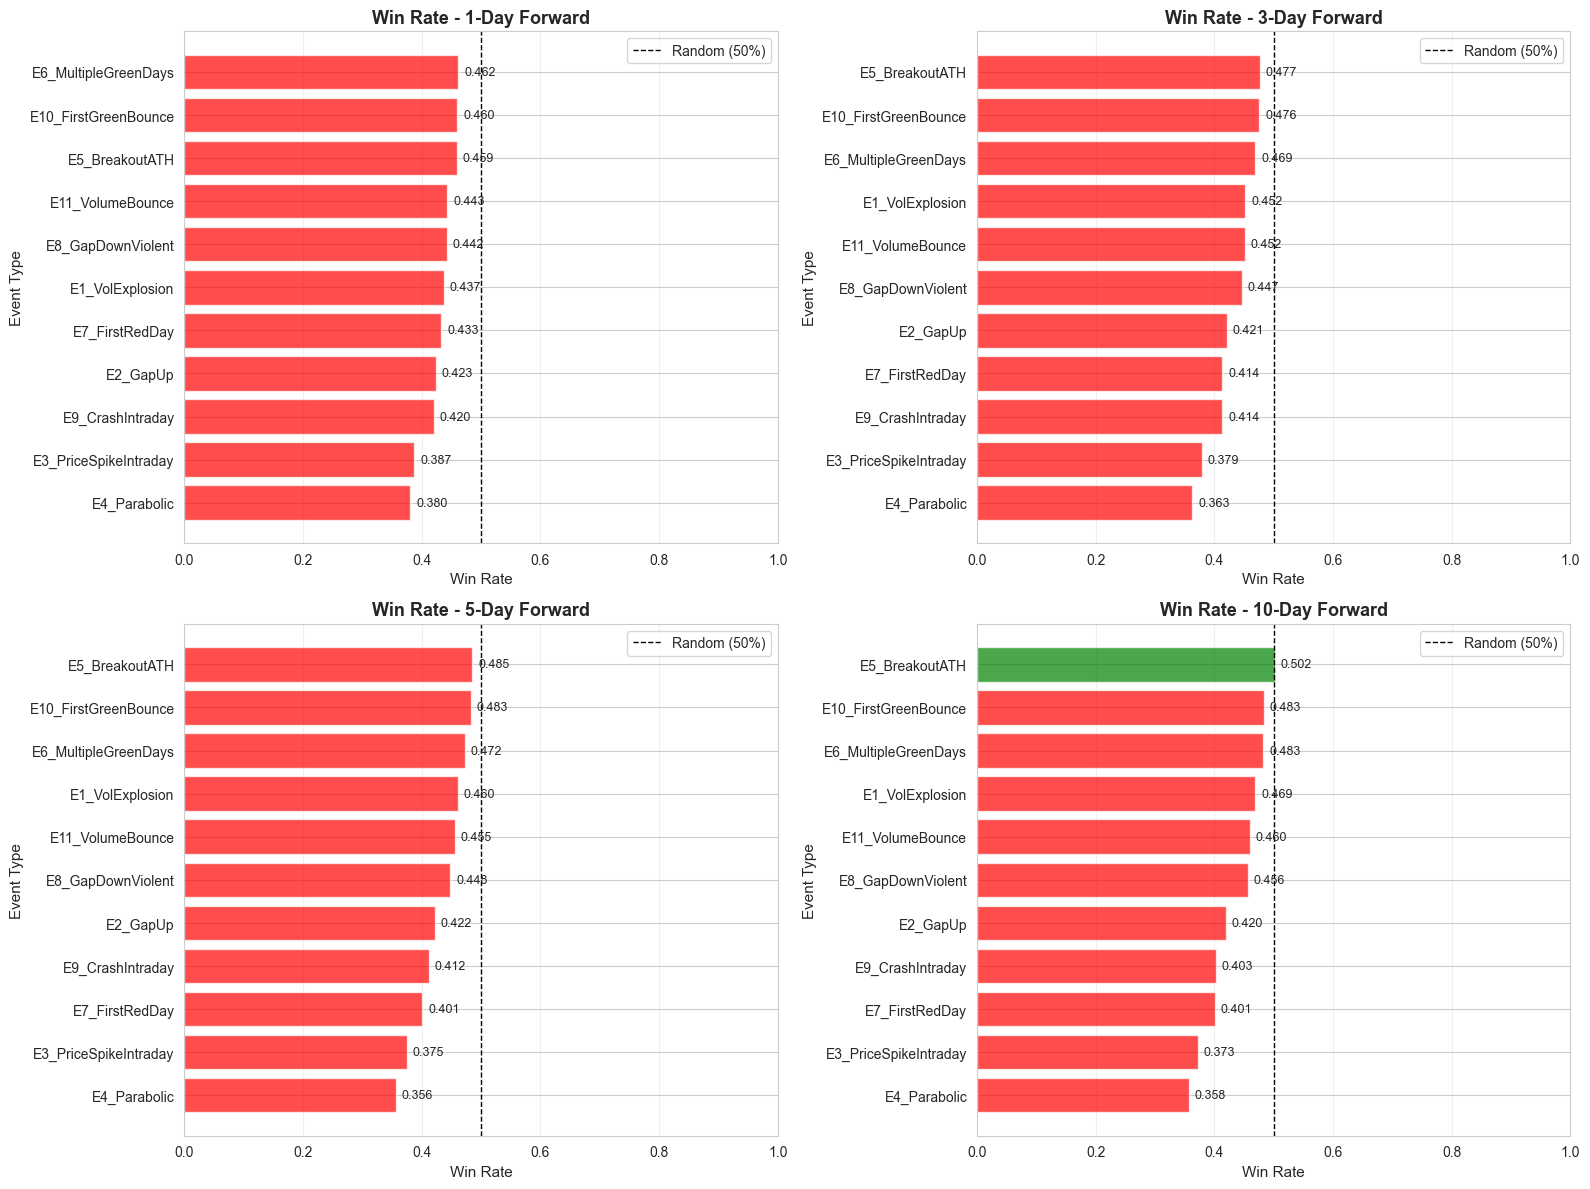

[OK] Plot saved: win_rate_by_event_horizon.png


In [9]:
# Plot: Win rate by event and horizon
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
horizons = ['ret_1d', 'ret_3d', 'ret_5d', 'ret_10d']
titles = ['1-Day Forward', '3-Day Forward', '5-Day Forward', '10-Day Forward']

for ax, horizon, title in zip(axes.flat, horizons, titles):
    df_plot = df_single_performance.filter(pl.col('horizon') == horizon).to_pandas()
    df_plot = df_plot.sort_values('win_rate', ascending=True)
    
    colors = ['red' if wr < 0.5 else 'green' for wr in df_plot['win_rate']]
    
    ax.barh(df_plot['events'], df_plot['win_rate'], color=colors, alpha=0.7)
    ax.axvline(0.5, color='black', linestyle='--', linewidth=1, label='Random (50%)')
    ax.set_xlabel('Win Rate', fontsize=11)
    ax.set_ylabel('Event Type', fontsize=11)
    ax.set_title(f'Win Rate - {title}', fontsize=13, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.grid(axis='x', alpha=0.3)
    ax.legend()
    
    # Add value labels
    for i, (event, wr) in enumerate(zip(df_plot['events'], df_plot['win_rate'])):
        ax.text(wr + 0.01, i, f'{wr:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('win_rate_by_event_horizon.png', dpi=300, bbox_inches='tight')
plt.show()

print('[OK] Plot saved: win_rate_by_event_horizon.png')

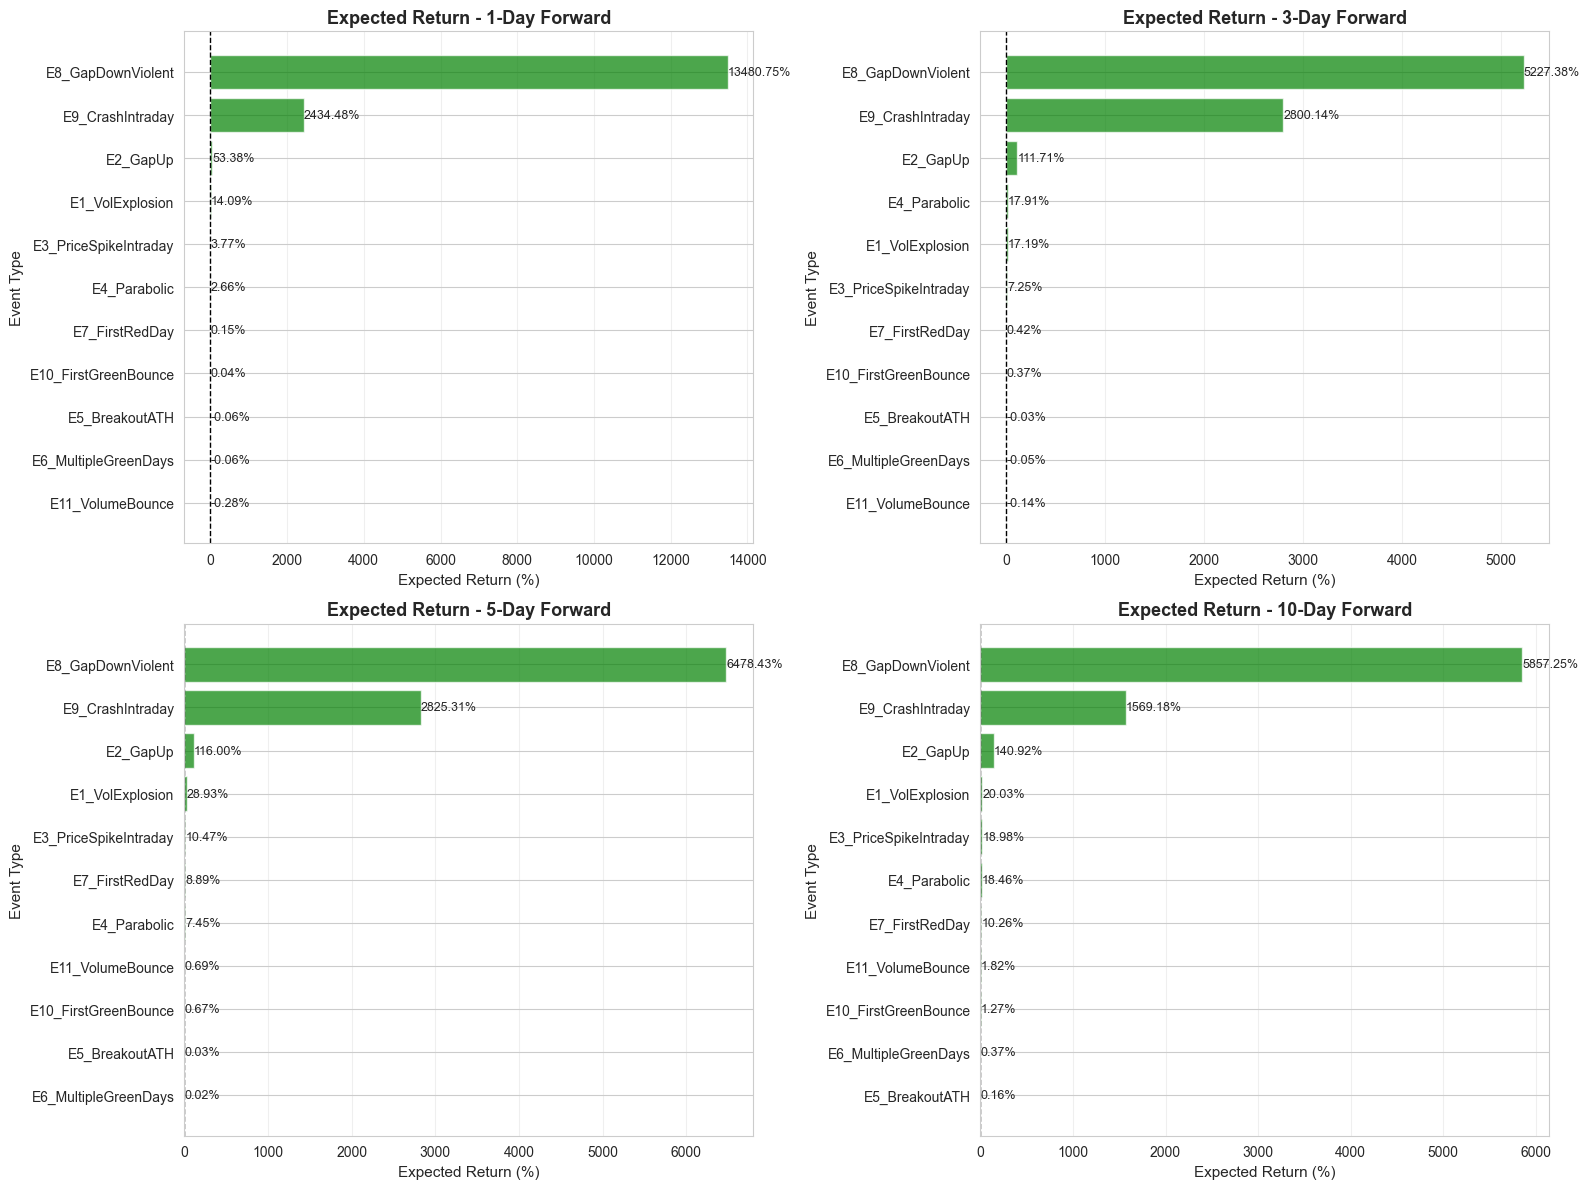

[OK] Plot saved: expected_return_by_event_horizon.png


In [10]:
# Plot: Expected return by event and horizon
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for ax, horizon, title in zip(axes.flat, horizons, titles):
    df_plot = df_single_performance.filter(pl.col('horizon') == horizon).to_pandas()
    df_plot = df_plot.sort_values('mean_ret', ascending=True)
    
    colors = ['red' if mr < 0 else 'green' for mr in df_plot['mean_ret']]
    
    ax.barh(df_plot['events'], df_plot['mean_ret'] * 100, color=colors, alpha=0.7)
    ax.axvline(0, color='black', linestyle='--', linewidth=1)
    ax.set_xlabel('Expected Return (%)', fontsize=11)
    ax.set_ylabel('Event Type', fontsize=11)
    ax.set_title(f'Expected Return - {title}', fontsize=13, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (event, mr) in enumerate(zip(df_plot['events'], df_plot['mean_ret'])):
        ax.text(mr*100 + 0.1, i, f'{mr*100:.2f}%', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('expected_return_by_event_horizon.png', dpi=300, bbox_inches='tight')
plt.show()

print('[OK] Plot saved: expected_return_by_event_horizon.png')

## 7. Event Combinations: Analyze 2-Event Combos

In [11]:
# Create binary matrix for event combinations
print('Creating event combination matrix...')

# Get all unique events
all_events = df_exploded['events'].unique().to_list()
print(f'Unique events: {len(all_events)}')
print(all_events)
print()

# Create binary columns for each event
df_combo = df_backtest.clone()

for event in all_events:
    df_combo = df_combo.with_columns([
        pl.col('events').list.contains(event).cast(pl.Int32).alias(f'has_{event}')
    ])

print('Binary event matrix created')
print()
print('Sample:')
print(df_combo.select(['ticker', 'date'] + [f'has_{e}' for e in all_events[:5]]).head(5))

Creating event combination matrix...
Unique events: 11
['E5_BreakoutATH', 'E9_CrashIntraday', 'E2_GapUp', 'E8_GapDownViolent', 'E1_VolExplosion', 'E11_VolumeBounce', 'E4_Parabolic', 'E6_MultipleGreenDays', 'E7_FirstRedDay', 'E10_FirstGreenBounce', 'E3_PriceSpikeIntraday']



Binary event matrix created

Sample:
shape: (5, 7)
┌────────┬────────────┬───────────────┬───────────────┬──────────────┬──────────────┬──────────────┐
│ ticker ┆ date       ┆ has_E5_Breako ┆ has_E9_CrashI ┆ has_E2_GapUp ┆ has_E8_GapDo ┆ has_E1_VolEx │
│ ---    ┆ ---        ┆ utATH         ┆ ntraday       ┆ ---          ┆ wnViolent    ┆ plosion      │
│ str    ┆ date       ┆ ---           ┆ ---           ┆ i32          ┆ ---          ┆ ---          │
│        ┆            ┆ i32           ┆ i32           ┆              ┆ i32          ┆ i32          │
╞════════╪════════════╪═══════════════╪═══════════════╪══════════════╪══════════════╪══════════════╡
│ AABA   ┆ 2017-07-05 ┆ 0             ┆ 0             ┆ 0            ┆ 0            ┆ 0            │
│ AABA   ┆ 2017-07-12 ┆ 0             ┆ 0             ┆ 0            ┆ 0            ┆ 0            │
│ AABA   ┆ 2017-07-18 ┆ 0             ┆ 0             ┆ 0            ┆ 0            ┆ 0            │
│ AABA   ┆ 2017-07-26 ┆ 0             ┆ 

In [12]:
# Analyze 2-event combinations
print('Analyzing 2-event combinations...')
print()

combo_results = []

for e1, e2 in combinations(all_events, 2):
    # Filter rows where both events occur
    df_both = df_combo.filter(
        (pl.col(f'has_{e1}') == 1) & (pl.col(f'has_{e2}') == 1)
    )
    
    if len(df_both) < 10:  # Skip if too few samples
        continue
    
    # Calculate metrics for each horizon
    for horizon in ['ret_1d', 'ret_3d', 'ret_5d', 'ret_10d']:
        df_valid = df_both.filter(pl.col(horizon).is_not_null())
        
        if len(df_valid) < 10:
            continue
        
        n_signals = len(df_valid)
        n_wins = (df_valid[horizon] > 0).sum()
        win_rate = n_wins / n_signals
        mean_ret = df_valid[horizon].mean()
        std_ret = df_valid[horizon].std()
        sharpe = mean_ret / std_ret if std_ret > 0 else 0
        
        combo_results.append({
            'combo': f'{e1} + {e2}',
            'event1': e1,
            'event2': e2,
            'horizon': horizon,
            'n_signals': n_signals,
            'win_rate': win_rate,
            'mean_ret': mean_ret,
            'std_ret': std_ret,
            'sharpe': sharpe
        })

df_combo_performance = pl.DataFrame(combo_results)
print(f'Analyzed {len(df_combo_performance):,} 2-event combinations')
print()

# Top 10 combinations by win rate (10d horizon)
print('Top 10 combinations by win rate (10-day horizon):')
top10_combos = (
    df_combo_performance
    .filter(pl.col('horizon') == 'ret_10d')
    .sort('win_rate', descending=True)
    .head(10)
)
print(top10_combos)
print()

# Save
df_combo_performance.write_csv('combo_2event_performance.csv')
print('[OK] Saved: combo_2event_performance.csv')

Analyzing 2-event combinations...



Analyzed 196 2-event combinations

Top 10 combinations by win rate (10-day horizon):
shape: (10, 9)
┌────────────┬────────────┬────────────┬─────────┬───┬──────────┬───────────┬──────────┬───────────┐
│ combo      ┆ event1     ┆ event2     ┆ horizon ┆ … ┆ win_rate ┆ mean_ret  ┆ std_ret  ┆ sharpe    │
│ ---        ┆ ---        ┆ ---        ┆ ---     ┆   ┆ ---      ┆ ---       ┆ ---      ┆ ---       │
│ str        ┆ str        ┆ str        ┆ str     ┆   ┆ f64      ┆ f64       ┆ f64      ┆ f64       │
╞════════════╪════════════╪════════════╪═════════╪═══╪══════════╪═══════════╪══════════╪═══════════╡
│ E5_Breakou ┆ E5_Breakou ┆ E1_VolExpl ┆ ret_10d ┆ … ┆ 0.505779 ┆ -0.003171 ┆ 0.248832 ┆ -0.012745 │
│ tATH + E1_ ┆ tATH       ┆ osion      ┆         ┆   ┆          ┆           ┆          ┆           │
│ VolExplosi ┆            ┆            ┆         ┆   ┆          ┆           ┆          ┆           │
│ …          ┆            ┆            ┆         ┆   ┆          ┆           ┆          ┆    

## 8. Visualize Top Event Combinations

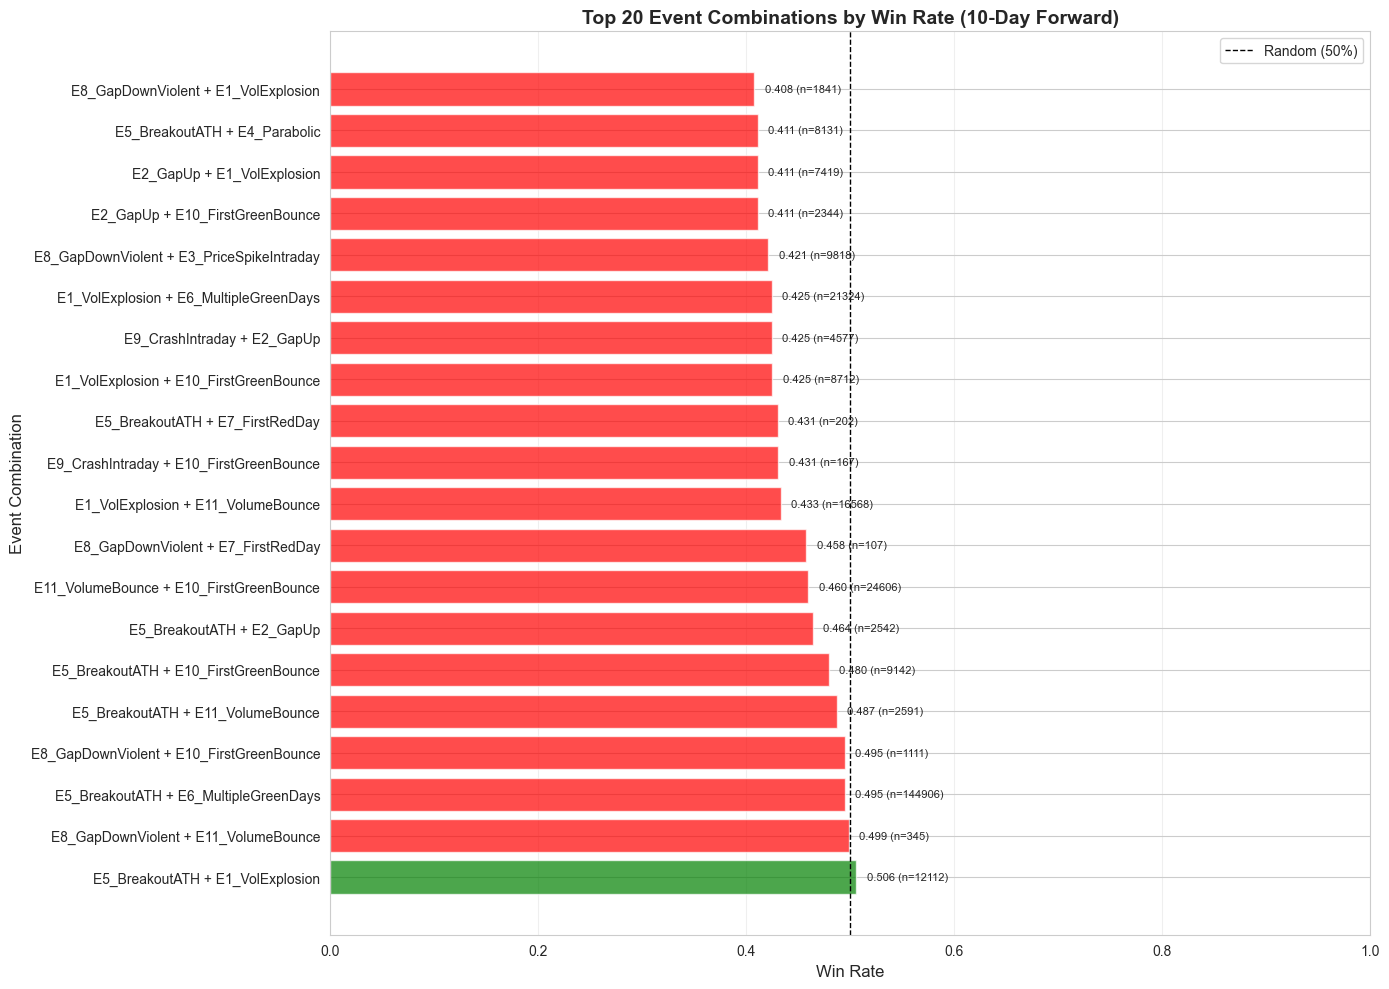

[OK] Plot saved: top20_combo_win_rate.png


In [13]:
# Plot: Top 20 combinations by win rate (10d horizon)
fig, ax = plt.subplots(figsize=(14, 10))

df_plot = (
    df_combo_performance
    .filter(pl.col('horizon') == 'ret_10d')
    .filter(pl.col('n_signals') >= 20)  # Require at least 20 signals
    .sort('win_rate', descending=True)
    .head(20)
    .to_pandas()
)

colors = ['green' if wr > 0.5 else 'red' for wr in df_plot['win_rate']]

ax.barh(df_plot['combo'], df_plot['win_rate'], color=colors, alpha=0.7)
ax.axvline(0.5, color='black', linestyle='--', linewidth=1, label='Random (50%)')
ax.set_xlabel('Win Rate', fontsize=12)
ax.set_ylabel('Event Combination', fontsize=12)
ax.set_title('Top 20 Event Combinations by Win Rate (10-Day Forward)', fontsize=14, fontweight='bold')
ax.set_xlim(0, 1)
ax.grid(axis='x', alpha=0.3)
ax.legend()

# Add value labels with n_signals
for i, (combo, wr, n) in enumerate(zip(df_plot['combo'], df_plot['win_rate'], df_plot['n_signals'])):
    ax.text(wr + 0.01, i, f'{wr:.3f} (n={n})', va='center', fontsize=8)

plt.tight_layout()
plt.savefig('top20_combo_win_rate.png', dpi=300, bbox_inches='tight')
plt.show()

print('[OK] Plot saved: top20_combo_win_rate.png')

## 9. Summary Report: Best Performers

In [14]:
print('=' * 80)
print('BACKTEST SUMMARY REPORT')
print('=' * 80)
print()

# Single events - best performers
print('SINGLE EVENT PERFORMANCE (10-Day Horizon):')
print()
best_single = (
    df_single_performance
    .filter(pl.col('horizon') == 'ret_10d')
    .sort('win_rate', descending=True)
    .head(5)
)

for row in best_single.iter_rows(named=True):
    print(f"  {row['events']}:")
    print(f"    Win Rate: {row['win_rate']:.3f}")
    print(f"    Expected Return: {row['mean_ret']*100:.2f}%")
    print(f"    Sharpe Ratio: {row['sharpe']:.3f}")
    print(f"    Signals: {row['n_signals']:,}")
    print()

# Combo events - best performers
print('=' * 80)
print('2-EVENT COMBO PERFORMANCE (10-Day Horizon):')
print()
best_combo = (
    df_combo_performance
    .filter(pl.col('horizon') == 'ret_10d')
    .filter(pl.col('n_signals') >= 20)
    .sort('win_rate', descending=True)
    .head(5)
)

for row in best_combo.iter_rows(named=True):
    print(f"  {row['combo']}:")
    print(f"    Win Rate: {row['win_rate']:.3f}")
    print(f"    Expected Return: {row['mean_ret']*100:.2f}%")
    print(f"    Sharpe Ratio: {row['sharpe']:.3f}")
    print(f"    Signals: {row['n_signals']:,}")
    print()

print('=' * 80)
print('[OK] BACKTEST COMPLETED')
print('=' * 80)

BACKTEST SUMMARY REPORT

SINGLE EVENT PERFORMANCE (10-Day Horizon):

  E5_BreakoutATH:
    Win Rate: 0.502
    Expected Return: 0.16%
    Sharpe Ratio: 0.010
    Signals: 407,670

  E10_FirstGreenBounce:
    Win Rate: 0.483
    Expected Return: 1.27%
    Sharpe Ratio: 0.007
    Signals: 809,745

  E6_MultipleGreenDays:
    Win Rate: 0.483
    Expected Return: 0.37%
    Sharpe Ratio: 0.004
    Signals: 1,536,405

  E1_VolExplosion:
    Win Rate: 0.469
    Expected Return: 20.03%
    Sharpe Ratio: 0.006
    Signals: 162,263

  E11_VolumeBounce:
    Win Rate: 0.460
    Expected Return: 1.82%
    Sharpe Ratio: 0.010
    Signals: 47,022

2-EVENT COMBO PERFORMANCE (10-Day Horizon):

  E5_BreakoutATH + E1_VolExplosion:
    Win Rate: 0.506
    Expected Return: -0.32%
    Sharpe Ratio: -0.013
    Signals: 12,112

  E8_GapDownViolent + E11_VolumeBounce:
    Win Rate: 0.499
    Expected Return: 13.28%
    Sharpe Ratio: 0.125
    Signals: 345

  E5_BreakoutATH + E6_MultipleGreenDays:
    Win Rate: